# GAT implementation, feature - centralities

In [37]:
!pip install torch-geometric
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: torch-scatter 2.1.1+pt20cu118
Uninstalling torch-scatter-2.1.1+pt20cu118:
  Successfully uninstalled torch-scatter-2.1.1+pt20cu118
Found existing installation: torch-sparse 0.6.17+pt20cu118
Uninstalling torch-sparse-0.6.17+pt20cu118:
  Successfully uninstalled torch-sparse-0.6.17+pt20cu118
Found existing installation: torch_geometric 2.4.0
Uninstalling torch_geometric-2.4.0:
  Successfully uninstalled torch_geometric-2.4.0
Found existing installation: torch-cluster 1.6.1+pt20cu118
Uninstalling torch-cluster-1.6.1+pt20cu118:
  Successfully uninstalled torch-cluster-1.6.1+pt20cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu118/torch_scatter-2.1.1%2Bpt20cu118-cp310-cp310-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu118/torch_sparse-0.6.17%2Bpt20cu118-cp310-cp310-linux_x86_64.whl (4.8 MB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu118/torch_cluster-1.6.1%2Bpt20cu118-cp310-cp310-linux_x86_64.whl (3.3 MB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-7jrywip2
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-7jrywip2
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 50cbd435d06803e64f3d131ef692499c0cfac09a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl size=928247 sha256=a21ef9064271732e56c53155769e07bed605333fd0ef8b7836ca223f0ae74e6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6mu3ymml/wheels/d3/78/eb/9e26525b948d19533f1688fb6c209cec8a0ba793d39b49ae8f
Successfully built torch_geometric


In [38]:
!pip install karateclub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import networkx as nx
import torch_geometric.utils as utils
import numpy as np
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch
import pandas as pd
import ast
from karateclub import GraphWave, Role2Vec, Node2Vec
from networkx.algorithms.centrality import closeness
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
from torch.nn import Linear, LeakyReLU
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch.nn import LayerNorm
from torch_geometric.loader import DataLoader

In [42]:
#Reading data from preprocessed balanced dataset
graph_df = pd.read_csv("/content/drive/MyDrive/CS286Potika/balanced_dataset_2000_graphs (1).csv")

In [43]:
graph_df

,GraphID,Nodes,Edges,Labels
0,4255,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[43, 0], [0, 43], [43, 1], [1, 43], [43, 2], ...",0
1,343,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[45, 0], [0, 45], [45, 1], [1, 45], [45, 2], ...",0
2,1319,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[43, 0], [0, 43], [43, 1], [1, 43], [43, 2], ...",0
3,2464,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[24, 0], [0, 24], [24, 1], [1, 24], [24, 2], ...",0
4,2068,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[[13, 0], [0, 13], [13, 1], [1, 13], [13, 2], ...",0
...,...,...,...,...
1995,8676,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[18, 0], [0, 18], [18, 1], [1, 18], [18, 2], ...",1
1996,8938,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[41, 0], [0, 41], [41, 1], [1, 41], [41, 2], ...",1
1997,3437,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[27, 0], [0, 27], [27, 1], [1, 27], [27, 2], ...",1
1998,1235,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[23, 0], [0, 23], [23, 1], [1, 23], [23, 2], ...",1


In [44]:
graph_df = graph_df.sample(frac=1)

### Creating graphs with centralities as features


In [45]:
import ast
import torch
import networkx as nx
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import Linear
from networkx.algorithms.centrality import katz_centrality, degree_centrality, betweenness_centrality

graph_list = []
i = 0
for row in graph_df.itertuples():
    # if i == 150:
    #     break
    ls = ast.literal_eval(row.Edges)
    tuple_list = [(x[0], x[1]) for x in ls]
    node_list = ast.literal_eval(row.Nodes)
    dataset1G = nx.Graph()
    dataset1G.add_edges_from(tuple_list)
    dataset1G.add_nodes_from(node_list)
    
    # Compute centrality coefficients and degree centrality
    degree = degree_centrality(dataset1G)
    betweeness = betweenness_centrality(dataset1G)

    # Add centrality coefficients and degree centrality as node features
    nx.set_node_attributes(dataset1G, degree, 'degree')
    nx.set_node_attributes(dataset1G, betweeness, 'betweeness')
    
    # Extract features from centrality coefficients and degree centrality
    degree_values = list(degree.values())
    betweeness_values = list(betweeness.values())

    feature_vec = [[d, b] for d, b in zip(degree_values, betweeness_values)]
    x = torch.tensor(feature_vec, dtype=torch.float)
    
    temp_var = int(row.Labels)
    dataset1G.graph['y'] = [temp_var]
    
    Graph_for_dataset = utils.from_networkx(dataset1G)
    Graph_for_dataset.x = x
    graph_list.append(Graph_for_dataset)
    i += 1

Defining the GAT model.

In [46]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12347)
        self.conv1 = GATConv(2, hidden_channels, heads=4)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.conv3 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.lin = Linear(hidden_channels * 4, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

model = GAT(hidden_channels=256)
print(model)

GAT(
  (conv1): GATConv(2, 256, heads=4)
  (conv2): GATConv(1024, 256, heads=4)
  (conv3): GATConv(1024, 256, heads=4)
  (conv4): GATConv(1024, 256, heads=4)
  (lin): Linear(in_features=1024, out_features=2, bias=True)
)


In [47]:
# Splitting and saving train and test dataset
train_dataset = graph_list[:1600]
val_dataset = graph_list[1600:]

Loading graphs in dataloaders

In [48]:
train_loader = DataLoader(train_dataset, batch_size=64)
# test_loader = DataLoader(test_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [49]:
for batch in val_loader:
  print(batch)

DataBatch(edge_index=[2, 9680], y=[64], degree=[1755], betweeness=[1755], num_nodes=1755, x=[1755, 2], batch=[1755], ptr=[65])
DataBatch(edge_index=[2, 11974], y=[64], degree=[1957], betweeness=[1957], num_nodes=1957, x=[1957, 2], batch=[1957], ptr=[65])
DataBatch(edge_index=[2, 11232], y=[64], degree=[1999], betweeness=[1999], num_nodes=1999, x=[1999, 2], batch=[1999], ptr=[65])
DataBatch(edge_index=[2, 10048], y=[64], degree=[1785], betweeness=[1785], num_nodes=1785, x=[1785, 2], batch=[1785], ptr=[65])
DataBatch(edge_index=[2, 11506], y=[64], degree=[1969], betweeness=[1969], num_nodes=1969, x=[1969, 2], batch=[1969], ptr=[65])
DataBatch(edge_index=[2, 10624], y=[64], degree=[1887], betweeness=[1887], num_nodes=1887, x=[1887, 2], batch=[1887], ptr=[65])
DataBatch(edge_index=[2, 3342], y=[16], degree=[510], betweeness=[510], num_nodes=510, x=[510, 2], batch=[510], ptr=[17])


In [50]:
model = GAT(hidden_channels=64)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GAT(
  (conv1): GATConv(2, 64, heads=4)
  (conv2): GATConv(256, 64, heads=4)
  (conv3): GATConv(256, 64, heads=4)
  (conv4): GATConv(256, 64, heads=4)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


In [51]:
# Training and Evaluation of the model

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with the highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive the ratio of correct predictions.

def validate(loader):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.y.size(0)

    return correct / total

all_train = []
all_test = []
all_val = []
for epoch in range(1, 20):
    train()
    train_acc = test(train_loader)
    all_train.append(train_acc)
    test_acc = test(val_loader)
    all_test.append(test_acc)
    # val_acc = validate(val_loader)
    # all_val.append(val_acc)
    # test_acc = validate(test_loader)
    print(f"Epoch: {epoch}, Train Acc: {train_acc:.4f}")

Epoch: 1, Train Acc: 0.6656
Epoch: 2, Train Acc: 0.6669
Epoch: 3, Train Acc: 0.6713
Epoch: 4, Train Acc: 0.6737
Epoch: 5, Train Acc: 0.6725
Epoch: 6, Train Acc: 0.6725
Epoch: 7, Train Acc: 0.6800
Epoch: 8, Train Acc: 0.6825
Epoch: 9, Train Acc: 0.6819
Epoch: 10, Train Acc: 0.6850
Epoch: 11, Train Acc: 0.6869
Epoch: 12, Train Acc: 0.6875
Epoch: 13, Train Acc: 0.6900
Epoch: 14, Train Acc: 0.6900
Epoch: 15, Train Acc: 0.6894
Epoch: 16, Train Acc: 0.6887
Epoch: 17, Train Acc: 0.6887
Epoch: 18, Train Acc: 0.6919
Epoch: 19, Train Acc: 0.6937


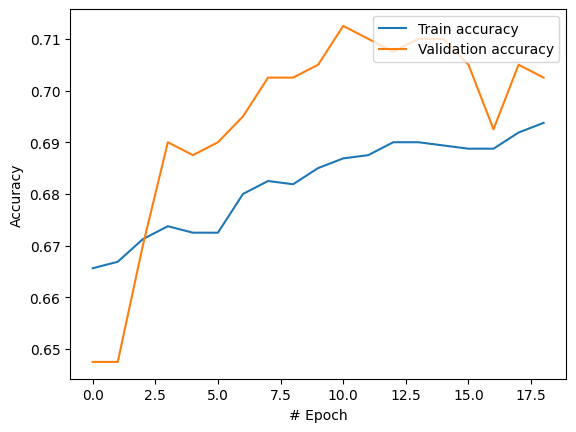

Test Acc: 0.7025
[[133  56]
 [ 63 148]]


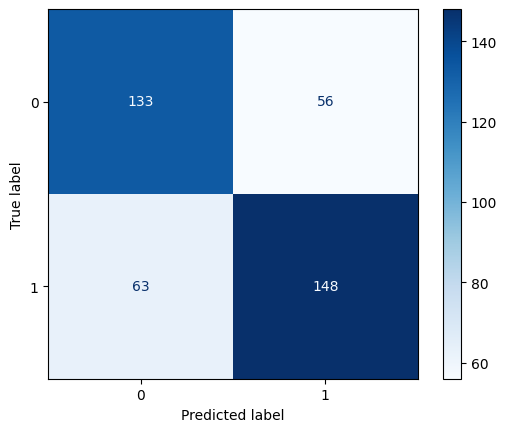

In [52]:
#Plotting the test/train graph and confusion matrix

plt.plot(all_train, label="Train accuracy")
# plt.plot(all_val, label="Validation accuracy")
plt.plot(all_test, label="Validation accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.show()

# Evaluate the model on the test dataset
test_acc = validate(val_loader)
print(f"Test Acc: {test_acc:.4f}")

# Get predictions and true labels for the test dataset
y_pred = []
y_true = []
with torch.no_grad():
    for data in val_loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        y_pred.extend(pred.tolist())
        y_true.extend(data.y.tolist())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

Getting the final predictions from the model

In [53]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       189
           1       0.73      0.70      0.71       211

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400



# Improving GAT Model

GAT model with early stopping

Epoch: 1, Train Acc: 0.6887
Epoch: 2, Train Acc: 0.6869
Epoch: 3, Train Acc: 0.6887
Epoch: 4, Train Acc: 0.6900
Epoch: 5, Train Acc: 0.6931
Epoch: 6, Train Acc: 0.6956
Early stopping triggered. No improvement in validation accuracy.
Test Acc: 0.7000


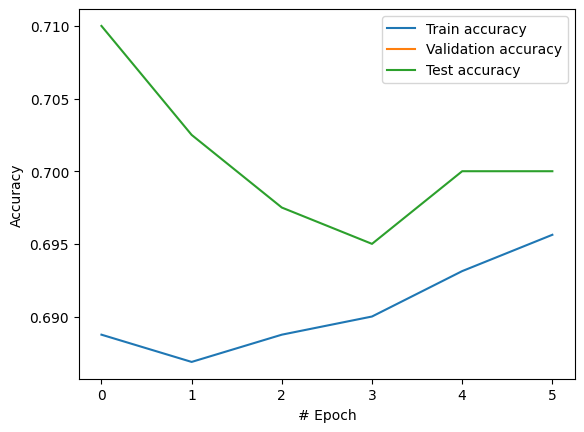

In [54]:
import matplotlib.pyplot as plt

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
best_test_acc = 0.0
best_model_state_dict = None
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter for epochs without improvement

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with the highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive the ratio of correct predictions.

def validate(loader):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.y.size(0)

    return correct / total

all_train = []
all_test = []
all_val = []
for epoch in range(1, 20):
    train()
    train_acc = validate(train_loader)
    all_train.append(train_acc)
    # val_acc = validate(val_loader)
    # all_val.append(val_acc)
    test_acc = validate(val_loader)
    all_test.append(test_acc)
    print(f"Epoch: {epoch}, Train Acc: {train_acc:.4f}")

    # Implementing early stopping
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model_state_dict = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. No improvement in validation accuracy.")
            break

test_acc = validate(val_loader)
print(f"Test Acc: {test_acc:.4f}")

# Load the best model state dict
model.load_state_dict(best_model_state_dict)

plt.plot(all_train, label="Train accuracy")
plt.plot(all_val, label="Validation accuracy")
plt.plot(all_test, label="Test accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
#Hyperparameter tuning with Bayesian Optimization 

!pip install optuna
import optuna

def objective(trial):
    # Define the hyperparameter search space
    hidden_channels = trial.suggest_int("hidden_channels", 64, 256)
    num_heads = trial.suggest_int("num_heads", 1, 8)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.7)
    num_layers = trial.suggest_int("num_layers", 1, 4)

    model = GAT1(hidden_channels=hidden_channels, num_heads=num_heads, num_layers=num_layers)
    optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

    all_train = []
    all_val = []
    for epoch in range(1, 20):
        train()
        train_acc = validate(train_loader)
        all_train.append(train_acc)
        val_acc = validate(val_loader)
        all_val.append(val_acc)

    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_model = GAT(hidden_channels=best_params['hidden_channels'], num_heads=best_params['num_heads'],
                 num_layers=best_params['num_layers'])

# Train the best model using the optimal hyperparameters
for epoch in range(1, 20):
    train()
    train_acc = validate(train_loader)
    all_train.append(train_acc)
    val_acc = validate(val_loader)
    all_val.append(val_acc)
    test_acc = validate(test_loader)
    all_test.append(test_acc)
    print(f"Epoch: {epoch}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

test_acc = validate(test_loader)
print(f"Test Acc: {test_acc:.4f}")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.2 MB/s eta 0:00:00


[I 2023-05-15 18:49:33,462] A new study created in memory with name: no-name-97e0c960-243c-4714-ad2d-76e9f0da5bb0
[I 2023-05-15 18:53:31,821] Trial 0 finished with value: 0.685 and parameters: {'hidden_channels': 236, 'num_heads': 4, 'learning_rate': 0.008634091999761676, 'dropout_rate': 0.2727053046451946, 'num_layers': 3}. Best is trial 0 with value: 0.685.
[I 2023-05-15 18:57:24,432] Trial 1 finished with value: 0.715 and parameters: {'hidden_channels': 172, 'num_heads': 6, 'learning_rate': 0.006586918410553608, 'dropout_rate': 0.5968173238474659, 'num_layers': 2}. Best is trial 1 with value: 0.715.
[I 2023-05-15 19:01:18,648] Trial 2 finished with value: 0.7 and parameters: {'hidden_channels': 152, 'num_heads': 4, 'learning_rate': 0.003500326819264269, 'dropout_rate': 0.5078248998324084, 'num_layers': 4}. Best is trial 1 with value: 0.715.
[I 2023-05-15 19:05:18,731] Trial 3 finished with value: 0.705 and parameters: {'hidden_channels': 249, 'num_heads': 5, 'learning_rate': 0.00694

# GAT Implementation with Role2Vec Graph Generation

In [55]:
# Role2VEc
model1 = GraphWave()
model2 = Role2Vec(walk_length=20)
model3 = Node2Vec(walk_length=20)


graph_list_2 = []
i=0
for row in graph_df.itertuples():
  if i == 2000:
    break
  ls = ast.literal_eval(row.Edges)
  tuple_list = [(x[0], x[1]) for x in ls]
  node_list = ast.literal_eval(row.Nodes)
  dataset1G = nx.Graph()
  dataset1G.add_edges_from(tuple_list)
  dataset1G.add_nodes_from(node_list)

  model2.fit(dataset1G)
  feature_vec = model2.get_embedding()

  x = torch.tensor(feature_vec, dtype = torch.float)
  temp_var = (int(row.Labels))

  dataset1G.graph['y'] = [temp_var]

  Graph_for_dataset = utils.from_networkx(dataset1G)
  Graph_for_dataset.x = x

  graph_list_2.append(Graph_for_dataset)
  i+=1

In [56]:
train_dataset = graph_list[:1600]
val_dataset = graph_list[1600:]

In [57]:
train_loader = DataLoader(train_dataset, batch_size=64)
# test_loader = DataLoader(test_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [58]:
for batch in val_loader:
  print(batch)

DataBatch(edge_index=[2, 4236], y=[32], degree=[836], betweeness=[836], num_nodes=836, x=[836, 2], batch=[836], ptr=[33])
DataBatch(edge_index=[2, 5444], y=[32], degree=[919], betweeness=[919], num_nodes=919, x=[919, 2], batch=[919], ptr=[33])
DataBatch(edge_index=[2, 5282], y=[32], degree=[949], betweeness=[949], num_nodes=949, x=[949, 2], batch=[949], ptr=[33])
DataBatch(edge_index=[2, 6692], y=[32], degree=[1008], betweeness=[1008], num_nodes=1008, x=[1008, 2], batch=[1008], ptr=[33])
DataBatch(edge_index=[2, 6960], y=[32], degree=[1056], betweeness=[1056], num_nodes=1056, x=[1056, 2], batch=[1056], ptr=[33])
DataBatch(edge_index=[2, 4272], y=[32], degree=[943], betweeness=[943], num_nodes=943, x=[943, 2], batch=[943], ptr=[33])
DataBatch(edge_index=[2, 5582], y=[32], degree=[967], betweeness=[967], num_nodes=967, x=[967, 2], batch=[967], ptr=[33])
DataBatch(edge_index=[2, 4466], y=[32], degree=[818], betweeness=[818], num_nodes=818, x=[818, 2], batch=[818], ptr=[33])
DataBatch(edge

In [62]:
#Defining GAT model
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12347)
        self.conv1 = GATConv(2, hidden_channels, heads=4)  # Update input dimension
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.conv3 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.lin = Linear(hidden_channels * 4, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x.view(x.size(0), -1))  # Reshape x before passing through the linear layer
        return x

model = GAT(hidden_channels=256)
print(model)

model = GAT(hidden_channels=64)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
print(model)


GAT(
  (conv1): GATConv(2, 256, heads=4)
  (conv2): GATConv(1024, 256, heads=4)
  (conv3): GATConv(1024, 256, heads=4)
  (conv4): GATConv(1024, 256, heads=4)
  (lin): Linear(in_features=1024, out_features=2, bias=True)
)
GAT(
  (conv1): GATConv(2, 64, heads=4)
  (conv2): GATConv(256, 64, heads=4)
  (conv3): GATConv(256, 64, heads=4)
  (conv4): GATConv(256, 64, heads=4)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


With Early Stopping

In [64]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with the highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive the ratio of correct predictions.

def validate(loader):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.y.size(0)

    return correct / total

all_train = []
all_test = []
all_val = []
for epoch in range(1, 20):
    train()
    train_acc = test(train_loader)
    all_train.append(train_acc)
    test_acc = test(val_loader)
    all_test.append(test_acc)
    # val_acc = validate(val_loader)
    # all_val.append(val_acc)
    # test_acc = validate(test_loader)
    print(f"Epoch: {epoch}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch: 1, Train Acc: 0.6669, Val Acc: 0.7025
Epoch: 2, Train Acc: 0.6700, Val Acc: 0.7025
Epoch: 3, Train Acc: 0.6713, Val Acc: 0.7025
Epoch: 4, Train Acc: 0.6725, Val Acc: 0.7025
Epoch: 5, Train Acc: 0.6813, Val Acc: 0.7025
Epoch: 6, Train Acc: 0.6813, Val Acc: 0.7025
Epoch: 7, Train Acc: 0.6837, Val Acc: 0.7025
Epoch: 8, Train Acc: 0.6837, Val Acc: 0.7025
Epoch: 9, Train Acc: 0.6844, Val Acc: 0.7025
Epoch: 10, Train Acc: 0.6875, Val Acc: 0.7025
Epoch: 11, Train Acc: 0.6869, Val Acc: 0.7025
Epoch: 12, Train Acc: 0.6881, Val Acc: 0.7025
Epoch: 13, Train Acc: 0.6869, Val Acc: 0.7025
Epoch: 14, Train Acc: 0.6850, Val Acc: 0.7025
Epoch: 15, Train Acc: 0.6875, Val Acc: 0.7025
Epoch: 16, Train Acc: 0.6913, Val Acc: 0.7025
Epoch: 17, Train Acc: 0.6919, Val Acc: 0.7025
Epoch: 18, Train Acc: 0.6925, Val Acc: 0.7025
Epoch: 19, Train Acc: 0.6937, Val Acc: 0.7025


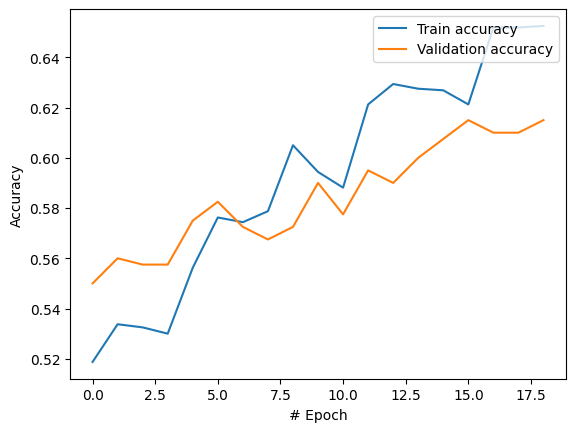

Test Acc: 0.6150
[[145  68]
 [ 86 101]]


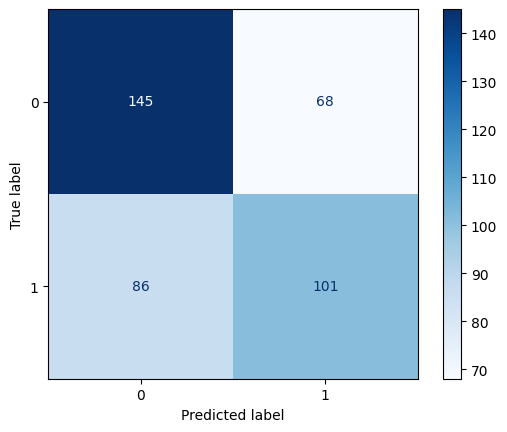

In [132]:
plt.plot(all_train, label="Train accuracy")
# plt.plot(all_val, label="Validation accuracy")
plt.plot(all_test, label="Validation accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.show()

# Evaluate the model on the test dataset
test_acc = validate(val_loader)
print(f"Test Acc: {test_acc:.4f}")

# Get predictions and true labels for the test dataset
y_pred = []
y_true = []
with torch.no_grad():
    for data in val_loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        y_pred.extend(pred.tolist())
        y_true.extend(data.y.tolist())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

Epoch: 1, Train Acc: 0.6900
Epoch: 2, Train Acc: 0.6850
Epoch: 3, Train Acc: 0.6944
Epoch: 4, Train Acc: 0.6944
Epoch: 5, Train Acc: 0.6950
Epoch: 6, Train Acc: 0.6950
Epoch: 7, Train Acc: 0.6931
Epoch: 8, Train Acc: 0.6981
Early stopping triggered. No improvement in validation accuracy.
Test Acc: 0.7025


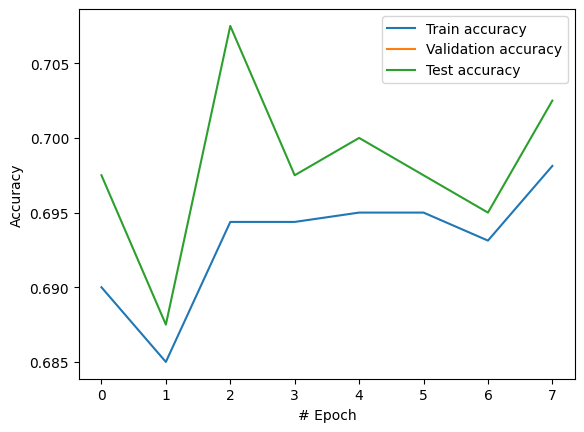

In [66]:
import matplotlib.pyplot as plt

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
best_test_acc = 0.0
best_model_state_dict = None
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter for epochs without improvement

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with the highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive the ratio of correct predictions.

def validate(loader):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.y.size(0)

    return correct / total

all_train = []
all_test = []
all_val = []
for epoch in range(1, 20):
    train()
    train_acc = validate(train_loader)
    all_train.append(train_acc)
    # val_acc = validate(val_loader)
    # all_val.append(val_acc)
    test_acc = validate(val_loader)
    all_test.append(test_acc)
    print(f"Epoch: {epoch}, Train Acc: {train_acc:.4f}")

    # Implementing early stopping
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model_state_dict = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. No improvement in validation accuracy.")
            break

test_acc = validate(val_loader)$
print(f"Test Acc: {test_acc:.4f}")

# Load the best model state dict
model.load_state_dict(best_model_state_dict)

plt.plot(all_train, label="Train accuracy")
plt.plot(all_val, label="Validation accuracy")
plt.plot(all_test, label="Test accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.show()

In [75]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       189
           1       0.72      0.65      0.68       211

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400



# GAT Implementation with GraphWave

In [67]:
model1 = GraphWave()
model2 = Role2Vec(walk_length=20)
model3 = Node2Vec(walk_length=20)


graph_list_2 = []
i=0
for row in graph_df.itertuples():
  if i == 2000:
    break
  ls = ast.literal_eval(row.Edges)
  tuple_list = [(x[0], x[1]) for x in ls]
  node_list = ast.literal_eval(row.Nodes)
  dataset1G = nx.Graph()
  dataset1G.add_edges_from(tuple_list)
  dataset1G.add_nodes_from(node_list)

  model1.fit(dataset1G)
  feature_vec = model1.get_embedding()

  x = torch.tensor(feature_vec, dtype = torch.float)
  temp_var = (int(row.Labels))

  dataset1G.graph['y'] = [temp_var]

  Graph_for_dataset = utils.from_networkx(dataset1G)
  Graph_for_dataset.x = x

  graph_list_2.append(Graph_for_dataset)
  i+=1

2023-05-15 18:32:15,633:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-05-15 18:32:15,906:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-05-15 18:32:16,118:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-05-15 18:32:16,355:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-05-15 18:32:16,486:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-05-15 18:32:16,598:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-05-15 18:32:16,708:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-05-15 18:32:16,967:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2023-05-15 18:32:17,070:[WARNING](pygsp.graphs.graph.che

In [68]:
train_dataset = graph_list_2[:1600]
val_dataset = graph_list_2[1600:]

In [69]:
train_loader = DataLoader(train_dataset, batch_size=64)
# test_loader = DataLoader(test_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [70]:
for batch in val_loader:
  print(batch)

DataBatch(edge_index=[2, 5072], y=[32], num_nodes=836, x=[836, 400], batch=[836], ptr=[33])
DataBatch(edge_index=[2, 6363], y=[32], num_nodes=919, x=[919, 400], batch=[919], ptr=[33])
DataBatch(edge_index=[2, 6231], y=[32], num_nodes=949, x=[949, 400], batch=[949], ptr=[33])
DataBatch(edge_index=[2, 7700], y=[32], num_nodes=1008, x=[1008, 400], batch=[1008], ptr=[33])
DataBatch(edge_index=[2, 8016], y=[32], num_nodes=1056, x=[1056, 400], batch=[1056], ptr=[33])
DataBatch(edge_index=[2, 5215], y=[32], num_nodes=943, x=[943, 400], batch=[943], ptr=[33])
DataBatch(edge_index=[2, 6549], y=[32], num_nodes=967, x=[967, 400], batch=[967], ptr=[33])
DataBatch(edge_index=[2, 5284], y=[32], num_nodes=818, x=[818, 400], batch=[818], ptr=[33])
DataBatch(edge_index=[2, 7757], y=[32], num_nodes=1025, x=[1025, 400], batch=[1025], ptr=[33])
DataBatch(edge_index=[2, 5718], y=[32], num_nodes=944, x=[944, 400], batch=[944], ptr=[33])
DataBatch(edge_index=[2, 6651], y=[32], num_nodes=1033, x=[1033, 400], 

In [71]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GATConv, global_mean_pool

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12347)
        self.conv1 = GATConv(400, hidden_channels, heads=4)  # Update input dimension
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.conv3 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.lin = Linear(hidden_channels * 4, 64)  # Update output size

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x.view(x.size(0), -1))  # Reshape x before passing through the linear layer
        return x

model = GAT(hidden_channels=64)
print(model)

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


GAT(
  (conv1): GATConv(400, 64, heads=4)
  (conv2): GATConv(256, 64, heads=4)
  (conv3): GATConv(256, 64, heads=4)
  (conv4): GATConv(256, 64, heads=4)
  (lin): Linear(in_features=256, out_features=64, bias=True)
)


In [72]:

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with the highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive the ratio of correct predictions.

def validate(loader):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.y.size(0)

    return correct / total

all_train = []
all_test = []
all_val = []
for epoch in range(1, 20):
    train()
    train_acc = test(train_loader)
    all_train.append(train_acc)
    test_acc = test(val_loader)
    all_test.append(test_acc)
    # val_acc = validate(val_loader)
    # all_val.append(val_acc)
    # test_acc = validate(test_loader)
    print(f"Epoch: {epoch}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch: 1, Train Acc: 0.5206, Val Acc: 0.7025
Epoch: 2, Train Acc: 0.5644, Val Acc: 0.7025
Epoch: 3, Train Acc: 0.6188, Val Acc: 0.7025
Epoch: 4, Train Acc: 0.6288, Val Acc: 0.7025
Epoch: 5, Train Acc: 0.6731, Val Acc: 0.7025
Epoch: 6, Train Acc: 0.6238, Val Acc: 0.7025
Epoch: 7, Train Acc: 0.6231, Val Acc: 0.7025
Epoch: 8, Train Acc: 0.6500, Val Acc: 0.7025
Epoch: 9, Train Acc: 0.6438, Val Acc: 0.7025
Epoch: 10, Train Acc: 0.6700, Val Acc: 0.7025
Epoch: 11, Train Acc: 0.6681, Val Acc: 0.7025
Epoch: 12, Train Acc: 0.6725, Val Acc: 0.7025
Epoch: 13, Train Acc: 0.6737, Val Acc: 0.7025
Epoch: 14, Train Acc: 0.6825, Val Acc: 0.7025
Epoch: 15, Train Acc: 0.6831, Val Acc: 0.7025
Epoch: 16, Train Acc: 0.6775, Val Acc: 0.7025
Epoch: 17, Train Acc: 0.6806, Val Acc: 0.7025
Epoch: 18, Train Acc: 0.6769, Val Acc: 0.7025
Epoch: 19, Train Acc: 0.6913, Val Acc: 0.7025


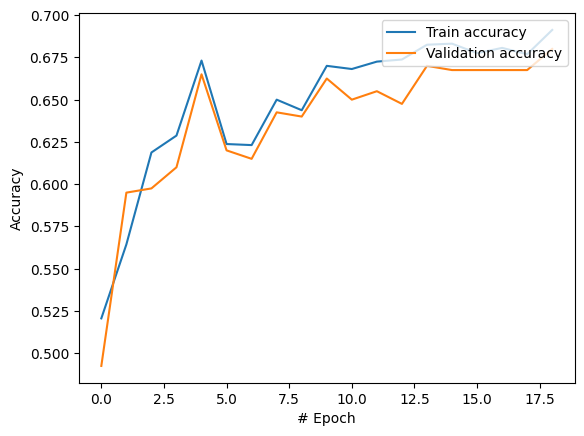

Test Acc: 0.6800
[[134  55]
 [ 73 138]]


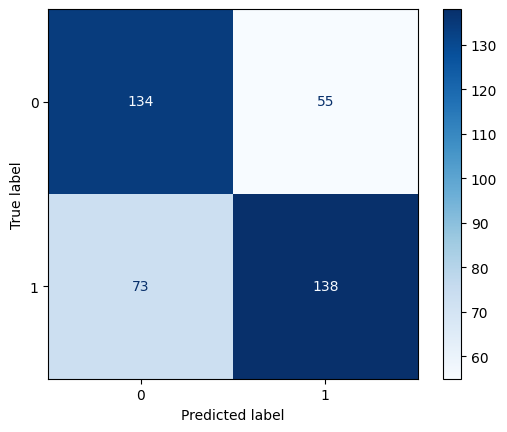

In [73]:
plt.plot(all_train, label="Train accuracy")
# plt.plot(all_val, label="Validation accuracy")
plt.plot(all_test, label="Validation accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.show()

# Evaluate the model on the test dataset
test_acc = validate(val_loader)
print(f"Test Acc: {test_acc:.4f}")

# Get predictions and true labels for the test dataset
y_pred = []
y_true = []
with torch.no_grad():
    for data in val_loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        y_pred.extend(pred.tolist())
        y_true.extend(data.y.tolist())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

In [74]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       189
           1       0.72      0.65      0.68       211

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400



In [ ]:
import matplotlib.pyplot as plt

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
best_test_acc = 0.0
best_model_state_dict = None
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter for epochs without improvement

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with the highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive the ratio of correct predictions.

def validate(loader):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.y.size(0)

    return correct / total

all_train = []
all_test = []
all_val = []
for epoch in range(1, 20):
    train()
    train_acc = validate(train_loader)
    all_train.append(train_acc)
    # val_acc = validate(val_loader)
    # all_val.append(val_acc)
    test_acc = validate(val_loader)
    all_test.append(test_acc)
    print(f"Epoch: {epoch}, Train Acc: {train_acc:.4f}")

    # Implementing early stopping
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model_state_dict = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. No improvement in validation accuracy.")
            break

test_acc = validate(val_loader)
print(f"Test Acc: {test_acc:.4f}")

# Load the best model state dict
model.load_state_dict(best_model_state_dict)

plt.plot(all_train, label="Train accuracy")
plt.plot(all_val, label="Validation accuracy")
plt.plot(all_test, label="Test accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.show()